# CNN from CIFAR10 raw data using PyTorch

## Importing packages

In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for evaluating results
from tqdm import tqdm # for progress bars
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

%matplotlib inline

In [2]:
print(f'Your torch version is {torch.__version__}')
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

Your torch version is 2.6.0


device(type='mps')

## Downloading CIFAR10 dataset


In [ ]:
Transform = ToTensor()
train_data = datasets.CIFAR10(
    root = '../data/',
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = '../data/', 
    train = False, 
    transform = Transform,
    download = True
)

## Printing train_data and test_data

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Visualization of CIFAR-10 dataset


Size: torch.Size([3, 32, 32]) Label: 6


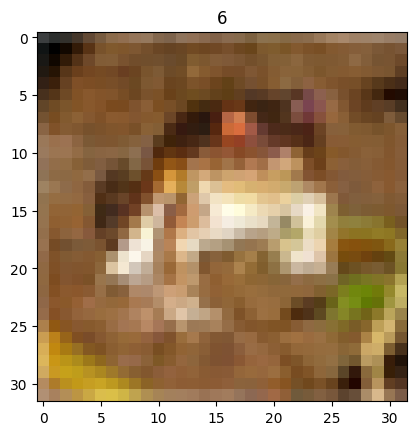

In [6]:
img, y_train = train_data[0]
print('Size:', img.size(), 'Label:', y_train)
plt.imshow(img.permute(1, 2, 0))
plt.title('%i' % y_train)
plt.show()

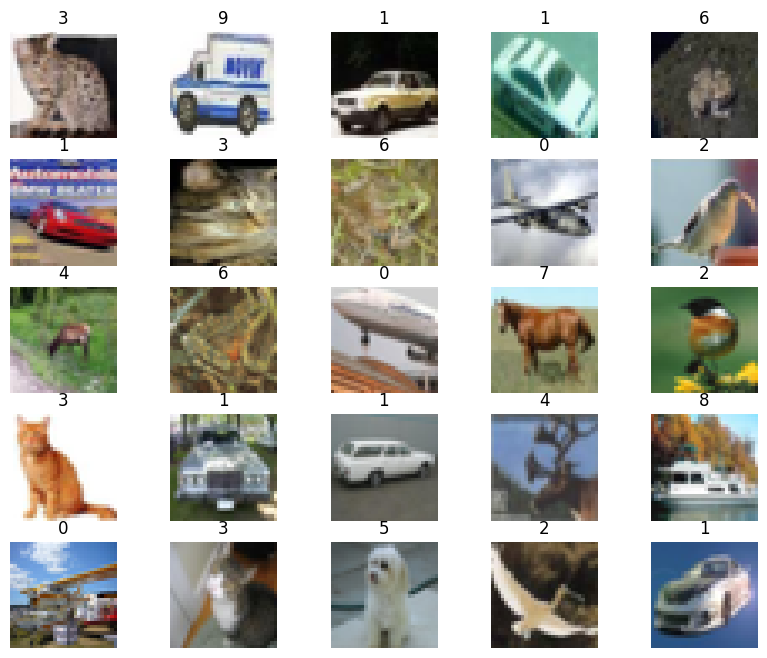

In [7]:
def show_imgs(X):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    plt.show()
    
show_imgs(train_data)

## Preparing data for training

In [8]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Simple CNN
## Building the Network

In [ ]:
class SimCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.relu = nn.ReLU() # When as module and in the forward pass one can use F.ReLU()
        self.pooling = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16*16*32, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pooling(x)
        x = self.flatten(x)
        # x = x.view(x.shape[0], -1)
        return self.fc(x)

model = SimCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0

## Training and evaluating the Model

Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [10]:
def train(epoch, model, data_loader, log_interval=200):
    
    model.train()
    total_train_loss = 0
    total_correct = 0

    for batch_idx, (X_train, y_train) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        output = model(X_train)
        loss = criterion(output, y_train)
        # Adding L2 norm
        loss += 0.05 * sum(p.norm(2) for p in model.parameters())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == y_train).item()
                  
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))
    
    accuracy_train = total_correct / len(data_loader.dataset)
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [11]:
@torch.inference_mode()

def validate(model, data_loader):
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).item()
        
        _, pred = torch.max(output, dim=1)
        total_correct += torch.sum(pred == target).item()

        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using validate().

In [12]:
%%time
epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   2%|▏         | 9/391 [00:01<00:43,  8.82it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.575660


Training Epoch 1:  54%|█████▍    | 212/391 [00:04<00:02, 64.97it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.911049


Validation: 100%|██████████| 79/79 [00:00<00:00, 81.02it/s] 



Validation set: Average loss: 1.4822, Accuracy: 5008/10000 (50.08%)



Training Epoch 2:   2%|▏         | 6/391 [00:00<00:06, 58.25it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.873268


Training Epoch 2:  53%|█████▎    | 209/391 [00:03<00:02, 65.04it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.995201


Validation: 100%|██████████| 79/79 [00:00<00:00, 118.68it/s]



Validation set: Average loss: 1.3914, Accuracy: 5227/10000 (52.27%)



Training Epoch 3:   2%|▏         | 7/391 [00:00<00:05, 66.75it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.902707


Training Epoch 3:  54%|█████▎    | 210/391 [00:03<00:02, 61.84it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.782688


Validation: 100%|██████████| 79/79 [00:00<00:00, 117.60it/s]



Validation set: Average loss: 1.3523, Accuracy: 5315/10000 (53.15%)



Training Epoch 4:   2%|▏         | 7/391 [00:00<00:06, 62.09it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.904098


Training Epoch 4:  54%|█████▎    | 210/391 [00:03<00:02, 65.31it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.863405


Validation: 100%|██████████| 79/79 [00:00<00:00, 121.05it/s]



Validation set: Average loss: 1.3424, Accuracy: 5344/10000 (53.44%)



Training Epoch 5:   2%|▏         | 7/391 [00:00<00:05, 65.92it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.857631


Training Epoch 5:  54%|█████▎    | 210/391 [00:03<00:02, 65.28it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.700916


Validation: 100%|██████████| 79/79 [00:00<00:00, 117.79it/s]


Validation set: Average loss: 1.3529, Accuracy: 5280/10000 (52.80%)

CPU times: user 22.9 s, sys: 2.98 s, total: 25.9 s
Wall time: 35.4 s


## Loss and Accuracy evaluation during training

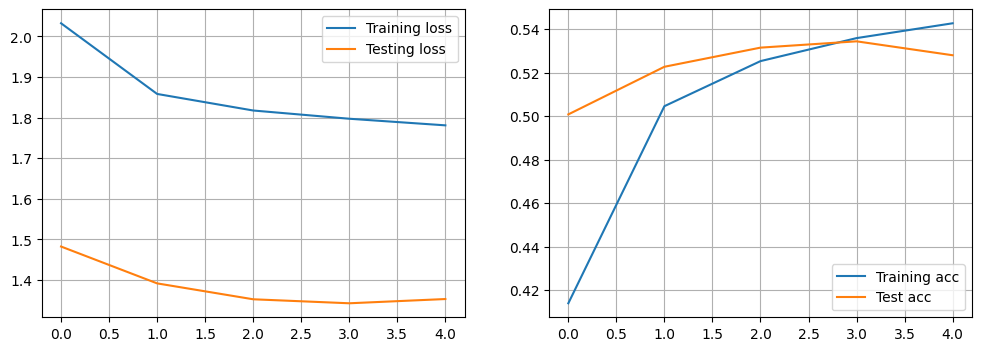

In [13]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

### Confusion matrix


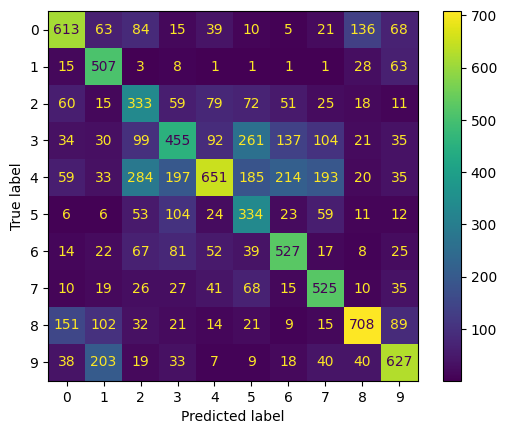

In [14]:
cm = confusion_matrix(val_result["predictions"], val_result["targets"])

disp = ConfusionMatrixDisplay(cm)
disp.plot()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

Weight of classification layer has size: torch.Size([10, 8192])


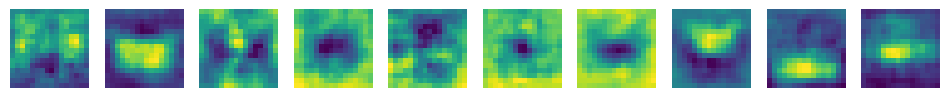

In [15]:
classifier_weight = model.fc.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(1, 10, i+1)

    weight_reshaped = weight.view(32, 16, 16)[:1]

    min_value = weight_reshaped.amin(dim=[1, 2], keepdim=True)
    max_value = weight_reshaped.amax(dim=[1, 2], keepdim=True)
    im = ((weight_reshaped - min_value) / (max_value - min_value + 1e-5) * 255).byte().numpy()
    
    ax.axis('off')
    ax.imshow(np.transpose(im, (1, 2, 0)))

plt.show()

#### Deeper CNN

In [26]:
class PreActResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        
        self.shortcut = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = F.relu(self.bn1(x))
        out = self.conv1(out)

        out = F.relu(self.bn2(out))
        out = self.conv2(out)

        out += identity
        return out

In [27]:
class DeepPreActCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.layer1 = PreActResBlock(32, 32)
        self.layer2 = PreActResBlock(32, 64, stride=2)
        self.layer3 = PreActResBlock(64, 128, stride=2)
        self.layer4 = PreActResBlock(128, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.avgpool(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        
        out = out.view(out.shape[0], -1)
        return self.fc(out)

In [28]:
model = DeepPreActCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─PreActResBlock: 1-2                    --
|    └─BatchNorm2d: 2-1                  64
|    └─Conv2d: 2-2                       9,248
|    └─BatchNorm2d: 2-3                  64
|    └─Conv2d: 2-4                       9,248
|    └─Identity: 2-5                     --
├─PreActResBlock: 1-3                    --
|    └─BatchNorm2d: 2-6                  64
|    └─Conv2d: 2-7                       18,496
|    └─BatchNorm2d: 2-8                  128
|    └─Conv2d: 2-9                       36,928
|    └─Sequential: 2-10                  --
|    |    └─Conv2d: 3-1                  2,048
|    |    └─BatchNorm2d: 3-2             128
├─PreActResBlock: 1-4                    --
|    └─BatchNorm2d: 2-11                 128
|    └─Conv2d: 2-12                      73,856
|    └─BatchNorm2d: 2-13                 256
|    └─Conv2d: 2-14                      147,584
|    └─Sequential: 2-15                 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─PreActResBlock: 1-2                    --
|    └─BatchNorm2d: 2-1                  64
|    └─Conv2d: 2-2                       9,248
|    └─BatchNorm2d: 2-3                  64
|    └─Conv2d: 2-4                       9,248
|    └─Identity: 2-5                     --
├─PreActResBlock: 1-3                    --
|    └─BatchNorm2d: 2-6                  64
|    └─Conv2d: 2-7                       18,496
|    └─BatchNorm2d: 2-8                  128
|    └─Conv2d: 2-9                       36,928
|    └─Sequential: 2-10                  --
|    |    └─Conv2d: 3-1                  2,048
|    |    └─BatchNorm2d: 3-2             128
├─PreActResBlock: 1-4                    --
|    └─BatchNorm2d: 2-11                 128
|    └─Conv2d: 2-12                      73,856
|    └─BatchNorm2d: 2-13                 256
|    └─Conv2d: 2-14                      147,584
|    └─Sequential: 2-15                 

In [29]:
%%time
epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   1%|          | 4/391 [00:02<02:37,  2.45it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 11.480499


Training Epoch 1:  52%|█████▏    | 205/391 [00:09<00:06, 26.76it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 7.280072


Validation: 100%|██████████| 79/79 [00:01<00:00, 51.79it/s]



Validation set: Average loss: 1.7346, Accuracy: 3573/10000 (35.73%)



Training Epoch 2:   1%|          | 3/391 [00:00<00:16, 22.96it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 6.137608


Training Epoch 2:  52%|█████▏    | 204/391 [00:07<00:07, 25.91it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 4.787895


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.05it/s]



Validation set: Average loss: 1.6174, Accuracy: 3738/10000 (37.38%)



Training Epoch 3:   1%|          | 3/391 [00:00<00:15, 24.83it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.768227


Training Epoch 3:  52%|█████▏    | 204/391 [00:08<00:07, 23.53it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.897299


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.28it/s]



Validation set: Average loss: 1.8196, Accuracy: 3834/10000 (38.34%)



Training Epoch 4:   1%|          | 3/391 [00:00<00:17, 22.65it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.594043


Training Epoch 4:  52%|█████▏    | 203/391 [00:10<00:10, 18.19it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.532736


Validation: 100%|██████████| 79/79 [00:01<00:00, 59.59it/s]



Validation set: Average loss: 2.2492, Accuracy: 2829/10000 (28.29%)



Training Epoch 5:   1%|          | 3/391 [00:00<00:17, 21.77it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.370198


Training Epoch 5:  52%|█████▏    | 204/391 [00:08<00:08, 23.08it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.169930


Validation: 100%|██████████| 79/79 [00:01<00:00, 57.09it/s]


Validation set: Average loss: 2.0420, Accuracy: 2933/10000 (29.33%)

CPU times: user 1min 15s, sys: 7.32 s, total: 1min 23s
Wall time: 1min 31s


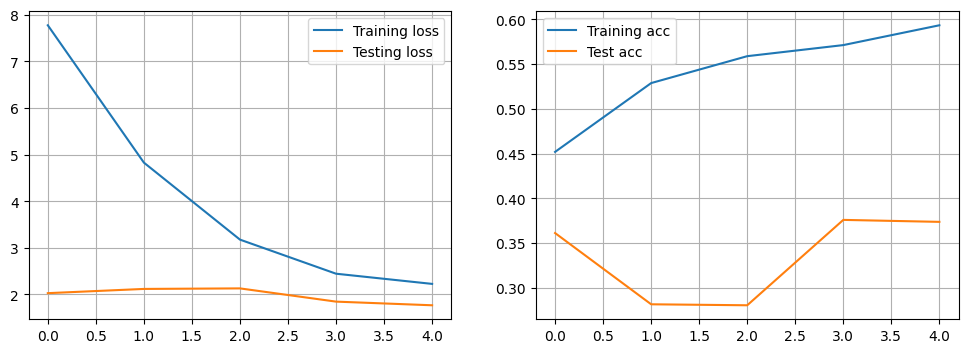

In [20]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

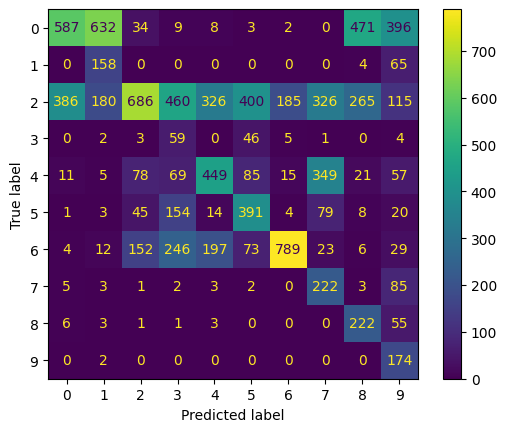

In [21]:
cm = confusion_matrix(val_result["predictions"], val_result["targets"])

disp = ConfusionMatrixDisplay(cm)
disp.plot()

Weight of classification layer has size: torch.Size([10, 256])


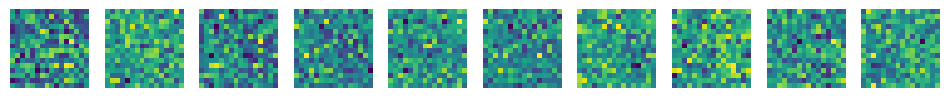

In [22]:
classifier_weight = model.fc.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))


for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)

    weight = classifier_weight[i]
    weight_reshaped = weight.view(1, 16, 16)

    min_value = weight_reshaped.amin(dim=[1, 2], keepdim=True)
    max_value = weight_reshaped.amax(dim=[1, 2], keepdim=True)
    im = ((weight_reshaped - min_value) / (max_value - min_value + 1e-5) * 255).byte().numpy()
    
    ax.axis('off')
    ax.imshow(np.transpose(im, (1, 2, 0)))

plt.show()

Training Epoch 1:   1%|          | 3/391 [00:00<00:31, 12.30it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 7.885697


Training Epoch 1:  52%|█████▏    | 203/391 [00:10<00:09, 19.75it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 5.121119


Validation: 100%|██████████| 79/79 [00:01<00:00, 49.56it/s]



Validation set: Average loss: 1.6368, Accuracy: 3841/10000 (38.41%)



Training Epoch 2:   1%|          | 2/391 [00:00<00:22, 17.59it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.222395


Training Epoch 2:  52%|█████▏    | 203/391 [00:10<00:09, 18.96it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 3.755915


Validation: 100%|██████████| 79/79 [00:01<00:00, 49.99it/s]



Validation set: Average loss: 1.4517, Accuracy: 4770/10000 (47.70%)



Training Epoch 3:   1%|          | 2/391 [00:00<00:24, 15.91it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.091997


Training Epoch 3:  52%|█████▏    | 204/391 [00:11<00:09, 19.28it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.772821


Validation: 100%|██████████| 79/79 [00:01<00:00, 49.98it/s]



Validation set: Average loss: 1.9443, Accuracy: 3258/10000 (32.58%)



Training Epoch 4:   1%|          | 2/391 [00:00<00:23, 16.84it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.351326


Training Epoch 4:  52%|█████▏    | 204/391 [00:10<00:09, 19.69it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.274219


Validation: 100%|██████████| 79/79 [00:01<00:00, 48.42it/s]



Validation set: Average loss: 1.5915, Accuracy: 4169/10000 (41.69%)



Training Epoch 5:   1%|          | 2/391 [00:00<00:21, 18.05it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.246898


Training Epoch 5:  52%|█████▏    | 202/391 [00:11<00:11, 16.92it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.283529


Validation: 100%|██████████| 79/79 [00:01<00:00, 46.07it/s]


Validation set: Average loss: 1.3638, Accuracy: 5080/10000 (50.80%)



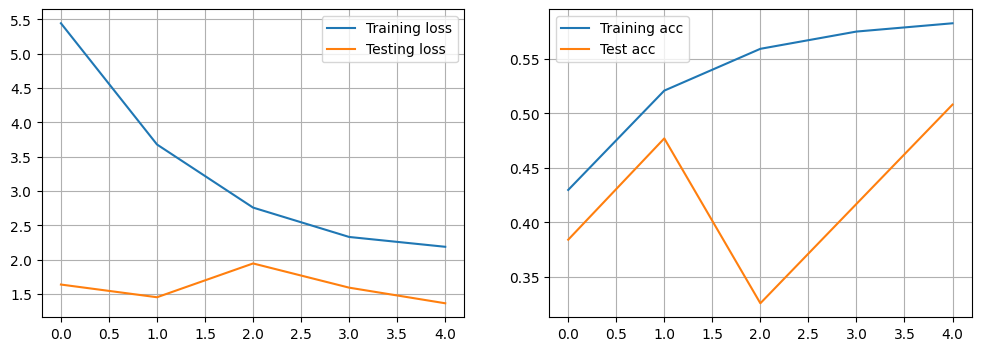

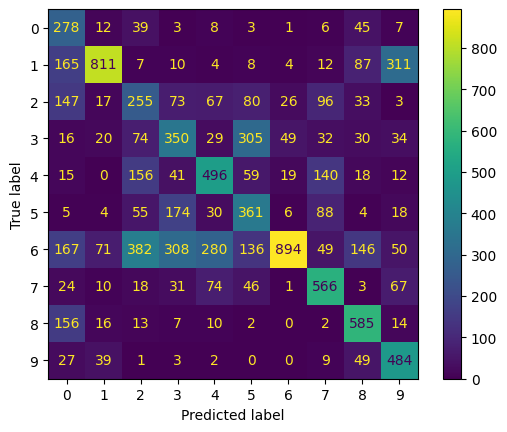

In [23]:
class DeepPreActCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.layer1 = PreActResBlock(32, 32)
        self.layer2 = PreActResBlock(32, 64, stride=2)
        self.layer3 = PreActResBlock(64, 128, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avgpool(out)
        out = out.view(out.shape[0], -1)
        return self.fc(out)
    

model = DeepPreActCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#%%time
epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

cm = confusion_matrix(val_result["predictions"], val_result["targets"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Training Epoch 1:   1%|          | 3/391 [00:00<01:09,  5.54it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 6.858723


Training Epoch 1:  52%|█████▏    | 204/391 [00:11<00:09, 18.90it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.680215


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.72it/s]



Validation set: Average loss: 1.5342, Accuracy: 4142/10000 (41.42%)



Training Epoch 2:   1%|          | 2/391 [00:00<00:20, 19.07it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 3.914987


Training Epoch 2:  52%|█████▏    | 204/391 [00:11<00:09, 18.75it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 3.343426


Validation: 100%|██████████| 79/79 [00:01<00:00, 51.57it/s]



Validation set: Average loss: 1.5289, Accuracy: 4648/10000 (46.48%)



Training Epoch 3:   1%|          | 2/391 [00:00<00:26, 14.89it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.880112


Training Epoch 3:  52%|█████▏    | 203/391 [00:10<00:09, 19.27it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.703204


Validation: 100%|██████████| 79/79 [00:01<00:00, 41.96it/s]



Validation set: Average loss: 1.5841, Accuracy: 4224/10000 (42.24%)



Training Epoch 4:   1%|          | 2/391 [00:00<00:22, 17.29it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.432537


Training Epoch 4:  52%|█████▏    | 204/391 [00:11<00:10, 17.07it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.171566


Validation: 100%|██████████| 79/79 [00:01<00:00, 43.20it/s]



Validation set: Average loss: 1.7656, Accuracy: 4384/10000 (43.84%)



Training Epoch 5:   1%|          | 2/391 [00:00<00:20, 18.78it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.169141


Training Epoch 5:  52%|█████▏    | 203/391 [00:11<00:10, 17.55it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.041920


Validation: 100%|██████████| 79/79 [00:01<00:00, 53.48it/s]


Validation set: Average loss: 1.4420, Accuracy: 4804/10000 (48.04%)



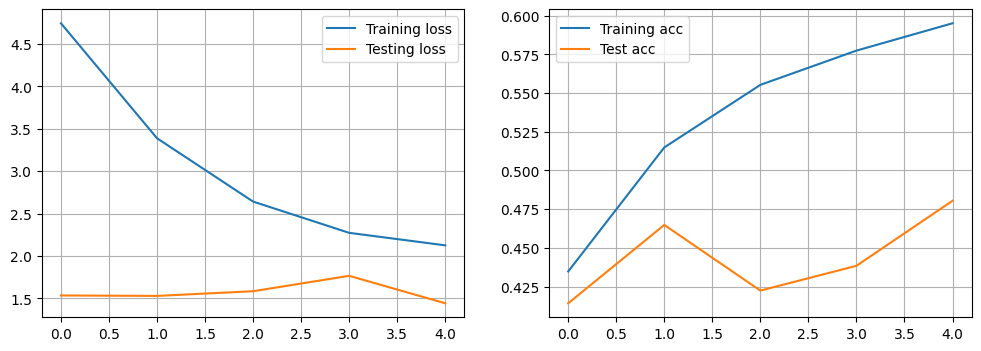

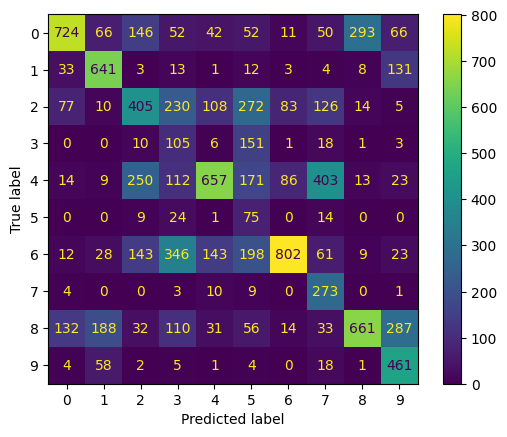

In [24]:
class DeepPreActCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.layer1 = PreActResBlock(32, 32)
        self.layer2 = PreActResBlock(32, 64, stride=2)
        self.layer3 = PreActResBlock(64, 32, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avgpool(out)
        out = out.view(out.shape[0], -1)
        return self.fc(out)
    

model = DeepPreActCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

cm = confusion_matrix(val_result["predictions"], val_result["targets"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [25]:
class DeepPreActCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.layer1 = PreActResBlock(32, 32)
        self.layer2 = PreActResBlock(32, 64, stride=2)
        self.layer3 = PreActResBlock(64, 32, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avgpool(out)
        out = out.view(out.shape[0], -1)
        return self.fc(out)
    

model = DeepPreActCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 30

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs+1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

cm = confusion_matrix(val_result["predictions"], val_result["targets"])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Training Epoch 1:   1%|          | 4/391 [00:00<00:20, 18.87it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 6.841633


Training Epoch 1:  52%|█████▏    | 203/391 [00:10<00:09, 19.64it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 4.590585


Validation: 100%|██████████| 79/79 [00:01<00:00, 53.13it/s]



Validation set: Average loss: 2.2129, Accuracy: 3058/10000 (30.58%)



Training Epoch 2:   1%|          | 2/391 [00:00<00:19, 19.78it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 4.000295


Training Epoch 2:  52%|█████▏    | 204/391 [00:10<00:09, 19.64it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 3.322745


Validation: 100%|██████████| 79/79 [00:01<00:00, 51.72it/s]



Validation set: Average loss: 1.4389, Accuracy: 4686/10000 (46.86%)



Training Epoch 3:   1%|          | 3/391 [00:00<00:18, 20.86it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 3.094568


Training Epoch 3:  52%|█████▏    | 204/391 [00:10<00:09, 19.68it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.497231


Validation: 100%|██████████| 79/79 [00:01<00:00, 53.85it/s]



Validation set: Average loss: 1.6667, Accuracy: 4093/10000 (40.93%)



Training Epoch 4:   1%|          | 3/391 [00:00<00:18, 20.71it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.454098


Training Epoch 4:  52%|█████▏    | 203/391 [00:10<00:09, 19.71it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.358754


Validation: 100%|██████████| 79/79 [00:01<00:00, 54.10it/s]



Validation set: Average loss: 2.4835, Accuracy: 2607/10000 (26.07%)



Training Epoch 5:   1%|          | 2/391 [00:00<00:19, 19.91it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 2.197096


Training Epoch 5:  52%|█████▏    | 203/391 [00:10<00:09, 19.51it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.074728


Validation: 100%|██████████| 79/79 [00:01<00:00, 53.22it/s]



Validation set: Average loss: 2.2098, Accuracy: 3596/10000 (35.96%)



Training Epoch 6:   1%|          | 2/391 [00:00<00:19, 19.56it/s]

Train Epoch: 6 [0/50000 (0%)]	Loss: 2.136949


Training Epoch 6:  52%|█████▏    | 203/391 [00:10<00:09, 19.72it/s]

Train Epoch: 6 [25600/50000 (51%)]	Loss: 2.071363


Validation: 100%|██████████| 79/79 [00:01<00:00, 43.89it/s]



Validation set: Average loss: 2.1951, Accuracy: 3385/10000 (33.85%)



Training Epoch 7:   1%|          | 2/391 [00:00<00:24, 16.05it/s]

Train Epoch: 7 [0/50000 (0%)]	Loss: 2.057775


Training Epoch 7:  52%|█████▏    | 204/391 [00:11<00:09, 19.24it/s]

Train Epoch: 7 [25600/50000 (51%)]	Loss: 2.088053


Validation: 100%|██████████| 79/79 [00:01<00:00, 45.34it/s]



Validation set: Average loss: 1.5320, Accuracy: 4600/10000 (46.00%)



Training Epoch 8:   1%|          | 2/391 [00:00<00:20, 18.59it/s]

Train Epoch: 8 [0/50000 (0%)]	Loss: 2.079501


Training Epoch 8:  52%|█████▏    | 204/391 [00:10<00:10, 18.55it/s]

Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.939126


Validation: 100%|██████████| 79/79 [00:01<00:00, 39.92it/s]



Validation set: Average loss: 1.9813, Accuracy: 3899/10000 (38.99%)



Training Epoch 9:   1%|          | 2/391 [00:00<00:21, 18.40it/s]

Train Epoch: 9 [0/50000 (0%)]	Loss: 2.208654


Training Epoch 9:  44%|████▍     | 173/391 [00:09<00:12, 17.92it/s]


KeyboardInterrupt: 